# Recognition of hailstorm events using the hail reports collected by the MeteoSwiss smartphone application

<p>
Andrey Martynov, February 2019
</p> 

<p>
AM: This work is based on the Tutorial V, given by Mykhailo Vladymyrov:
</p> 
<p>    
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [1]:
# AM: Libraries AND hail image files are unpacked at the first usage of the code, otherwise the following line shoud remain commented
#!tar -xvzf ./material.tgz
#!tar -xvzf ./hailimages_daily.tar

In [2]:
# AM: Importing required libraries

import sys
import os
import csv
import math
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from PIL import Image

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp
from utils import inception

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

In [3]:
# AM: loading the pre-trained inception model
def tfSessionLimited(graph=None):
    session_config=tf.ConfigProto( gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.85))
    session_config.gpu_options.visible_device_list = str(0) #use 1st gpu
    return tf.Session(graph=graph, config=session_config)

In [4]:
net, net_labels = inception.get_inception_model()

In [5]:
#get model graph definition and NOT change it to use GPU
gd = net

str_dg = gd.SerializeToString()
#uncomment next line to use GPU acceleration
# AM: the code has been ran on CPUs, the next line is commented:
#str_dg = str_dg.replace(b'/cpu:0', b'/gpu:0') #a bit extreme approach, but works =)
gd = gd.FromString(str_dg)

#gr_disp.show(gd)

In [6]:
gd2 = tf.graph_util.extract_sub_graph(gd, ['output'])
g2 = tf.Graph() # full graph
with g2.as_default():
    tf.import_graph_def(gd2, name='inception')

In [7]:
names = [op.name for op in g2.get_operations()]


## 4. Build own regressor on top

We will now create a fully connected regressor the same way as in previous session. The only difference is that instead of raw image data as input we will use 2048 image features that Inceprion is trained to detect. We will classify images in 2 classes.

In [8]:
#

def fully_connected_layer(x, n_output, name=None, activation=None):
    """Fully connected layer.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=None)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=None):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

In [9]:
with g2.as_default():
    x = g2.get_tensor_by_name('inception/input:0')
    features = g2.get_tensor_by_name('inception/head0_bottleneck/reshape:0')
    
    #placeholder for the true one-hot label
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, 2])
        
    #one layer with 512 neurons with sigmoid activation and one with 2, softmax activation.
    L1, W1 = fully_connected_layer(features, 512, 'FC1', tf.nn.sigmoid )
    L2, W2 = fully_connected_layer(L1, 512, 'FC2', tf.nn.sigmoid )
    L3, W3 = fully_connected_layer(L2 , 2, 'FC3')
    Y_onehot = tf.nn.softmax(L3, name='Logits')
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    
    #cross-entropy used as a measure for qulity of each image.
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L3, labels=Y)
    
    #mean cross_entropy - for a set of images.
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    
    #Accuracy is defined as fraction of correctly recognized images.
    Y_true = tf.argmax(Y, 1)
    Correct = tf.equal(Y_true, Y_pred, name='CorrectY')
    Accuracy = tf.reduce_mean(tf.cast(Correct, dtype=tf.float32), name='Accuracy')

In [10]:
## Dataset

In [11]:
# AM: two labels: no radar hail and presence of radar hail
text_label = ['No Hail', 'Hail']


In [35]:
labels0 = []
images0 = []
labels1 = []
images1 = []

#NoHail

filenames=os.listdir("./NoHail_daily_80/")

#np.array(img.convert('RGB'))
for filename in filenames:
    img = np.array(Image.fromarray(plt.imread('./NoHail_daily_80/' + filename)).convert('RGB'))
    assert(img.shape[0]>=50 and img.shape[1]>=50 and len(img.shape)==3)
    images0.append(inception.prepare_training_img(img))
    labels0.append([1,0])
    
    
#Hail
filenames=os.listdir("./Hail_daily_80/")
for filename in filenames:
    img = np.array(Image.fromarray(plt.imread('./Hail_daily_80/' + filename)).convert('RGB'))
    assert(img.shape[0]>=50 and img.shape[1]>=50 and len(img.shape)==3)
    images1.append(inception.prepare_training_img(img))
    labels1.append([0,1])

#AM: permutation: different number of "hail" and "no hail" cases. while equal numbers are required.
#Ad hoc solution: permutation of "no hail", then additional permulation, only the number equal to that of "hail" cases is retained

#AM: saving the full no hail image set for a manual validation check
images0_full=images0

idx1 = np.random.permutation(len(labels1))
labels1 = np.array(labels1)[idx1]
images1 = np.array(images1)[idx1]

idx0 = np.random.permutation(len(labels0))
labels0 = np.array(labels0)[idx0]
images0 = np.array(images0)[idx0]
labels0 = np.array(labels0)[idx1]
images0 = np.array(images0)[idx1]

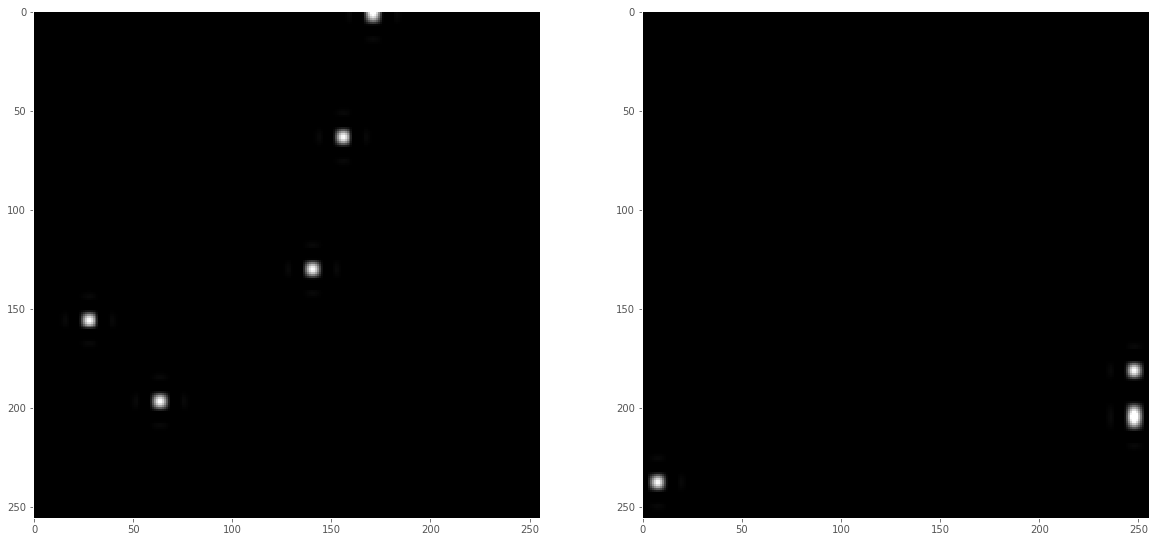

In [32]:
_, axs = plt.subplots(1, 2, figsize=(20,20))
img_d = inception.training_img_to_display(images0[20])
axs[0].imshow(img_d)
axs[0].grid(False)
img_d = inception.training_img_to_display(images1[20])
axs[1].imshow(img_d)
axs[1].grid(False)
plt.show()
#print(len(img_d))


0 0.6981132 0.64285713 0.6106265 0.6499051
1 0.8773585 0.75 0.593181 0.55111104
2 0.8962264 0.71428573 0.6086087 0.51826954
3 0.9245283 0.75 0.3200961 0.50824577
4 0.9339623 0.71428573 0.23415503 0.5022236
5 0.9339623 0.75 0.6252041 0.5024572
6 0.9433962 0.71428573 0.22063723 0.50032246
7 0.9433962 0.71428573 0.4101399 0.505041
8 0.9433962 0.71428573 0.13686126 0.5101286
9 0.9528302 0.71428573 0.27222234 0.5167939
10 0.9433962 0.71428573 0.111027956 0.51806945
11 0.9528302 0.75 0.10501289 0.5214824
12 0.9528302 0.71428573 0.2401352 0.5262472
13 0.9528302 0.75 0.09132068 0.5280977
14 0.9528302 0.71428573 0.08821175 0.5346216
15 0.9528302 0.75 0.17943321 0.5378582
16 0.9528302 0.71428573 0.15813325 0.5489879
17 0.9528302 0.75 0.1017081 0.5545674
18 0.9622642 0.75 0.05181717 0.5578207
19 0.9811321 0.75 0.05875092 0.56642264
20 0.9811321 0.75 0.0456597 0.5764017
21 0.990566 0.75 0.037845373 0.58621794
22 0.990566 0.75 0.05435881 0.57731146
23 0.990566 0.75 0.015219038 0.5953771
24 1.0 0.75

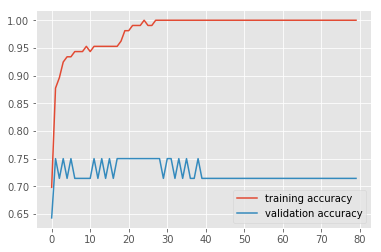

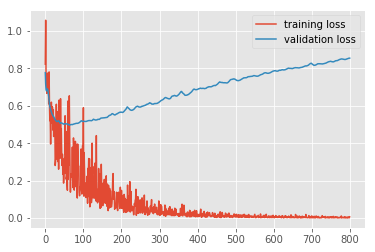

In [14]:
#We will take 80% from each for training and 20 for validation

#AM: separation between "hail" and "no hail" events: not finished yet

n_half0 = images0.shape[0]
n_train_half0 = n_half0*80//100
n_train0 = n_train_half0*2

n_half1 = images1.shape[0]
n_train_half1 = n_half1*80//100
n_train1 = n_train_half1*2

x_train = np.r_[images0[:n_train_half0], images1[:n_train_half1]]
y_train = np.r_[labels0[:n_train_half0], labels1[:n_train_half1]]

x_valid = np.r_[images0[n_train_half0:], images1[n_train_half1:]]
y_valid = np.r_[labels0[n_train_half0:], labels1[n_train_half1:]]

mini_batch_size = 10

#directory where the model will be stored
try:
    os.mkdir('Hail_80_output')
except:
    pass

with tfSessionLimited(graph=g2) as sess:
    #initialize all the variables 
    a_tr = []
    a_vld = []
    losses_t = []
    losses_v = []

    #create saver
    saver = tf.train.Saver(tf.global_variables())
    sess.run(tf.global_variables_initializer())
    
    saver.export_meta_graph(os.path.join('Hail_80_output', 'model.meta'))

    for epoch in range (80):
        #shuffle the data and perform stochastic gradient descent by runing over all minibatches
        idx0 = np.random.permutation(n_train0)
        idx1 = np.random.permutation(n_train1)
        for mb in range(n_train1//mini_batch_size):
            sub_idx = idx1[mini_batch_size*mb:mini_batch_size*(mb+1)]
            _, l = sess.run((optimizer, loss), feed_dict={x:x_train[sub_idx], Y:y_train[sub_idx]})
            l_v = sess.run(loss, feed_dict={x:x_valid, Y:y_valid})
            losses_t.append(np.mean(l))
            losses_v.append(np.mean(l_v))

        #get accuracy on the training set and test set
        accuracy_train = sess.run(Accuracy, feed_dict={x:x_train, Y:y_train})
        accuracy_valid = sess.run(Accuracy, feed_dict={x:x_valid, Y:y_valid})
        
        #every 10th epoch print accuracies and current loss
#        if epoch%10 == 0:
        print(epoch,accuracy_train, accuracy_valid, l,l_v)

        a_tr.append(accuracy_train)
        a_vld.append(accuracy_valid)
    
    #save the graph state, checkpoint ch-0
    checkpoint_prefix = os.path.join('Hail_80_output', 'ch')
    saver.save(sess, checkpoint_prefix, global_step=0, latest_filename='ch_last')
  
plt.plot(a_tr)
plt.plot(a_vld)
plt.legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

plt.plot(losses_t)
plt.plot(losses_v)
plt.legend(('training loss','validation loss'), loc='upper right')
plt.show()

In [36]:
with tfSessionLimited(graph=g2) as sess:
    #create saver and restore values
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join('Hail_80_output', 'ch-0'))

 
    #check that we still get proper performance oh a random image: no hail, full dataset
    r0f = sess.run(Y_onehot, feed_dict={x:images0_full[:]})
    print("NoHail")
    print(r0f)

#    #check that we still get proper performance oh a random image: no hail
#    r0 = sess.run(Y_onehot, feed_dict={x:images0[:]})
#    print("NoHail")
#    print(r0)
    
#    #check that we still get proper performance oh a random image: hail
#    r1 = sess.run(Y_onehot, feed_dict={x:images1[:]})
#    print("Hail")    
#    print(r1)
    


INFO:tensorflow:Restoring parameters from Hail_80_output/ch-0
NoHail
[[9.95712876e-01 4.28716792e-03]
 [9.92775440e-01 7.22450996e-03]
 [9.96941268e-01 3.05868150e-03]
 [9.64260995e-01 3.57389525e-02]
 [2.64329433e-01 7.35670567e-01]
 [5.65432787e-01 4.34567153e-01]
 [9.67322588e-01 3.26774158e-02]
 [9.28556085e-01 7.14439377e-02]
 [9.76281166e-01 2.37188525e-02]
 [9.84717071e-01 1.52829066e-02]
 [2.88485557e-01 7.11514354e-01]
 [9.91677880e-01 8.32217559e-03]
 [9.79201734e-01 2.07982250e-02]
 [5.90392292e-01 4.09607649e-01]
 [9.98114586e-01 1.88545312e-03]
 [9.93326664e-01 6.67331042e-03]
 [9.35731888e-01 6.42681047e-02]
 [9.97962713e-01 2.03725090e-03]
 [3.18251044e-01 6.81748986e-01]
 [9.96214211e-01 3.78571264e-03]
 [8.31053495e-01 1.68946534e-01]
 [9.98602927e-01 1.39706477e-03]
 [6.04074061e-01 3.95925939e-01]
 [9.93367612e-01 6.63242675e-03]
 [9.99135435e-01 8.64621892e-04]
 [9.91039693e-01 8.96025077e-03]
 [9.86001730e-01 1.39982346e-02]
 [9.15444314e-01 8.45557451e-02]
 [9.271